### homework1：完成卷积神经网络对衣服鞋子数据集的分类，并使用selu激活函数，对比效果

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据准备

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 这里用 random_split 按照 11 : 1 的比例来划分数据集
train_ds, val_ds = random_split(train_ds, [55000, 5000], torch.Generator().manual_seed(seed))

In [3]:
from torchvision.transforms import Normalize


# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


print(cal_mean_std(train_ds))

(tensor([0.2856]), tensor([0.3202]))


In [4]:
# 对每个通道进行标准化
transforms = nn.Sequential(
    Normalize([0.2856], [0.3202])
)

In [5]:
img, label = train_ds[0]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [6]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32
# 从数据集到dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

定义模型

In [7]:
class CNN(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        self.activation = F.relu if activation == "relu" else F.selu
        #输入通道数，图片是灰度图，所以是1，图片是彩色图，就是3，输出通道数，就是卷积核的个数（32,1,28,28）
        #输入x(32,1,28,28) 输出x(32,32,28,28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        #输入x(32,32,28,28) 输出x(32,32,28,28)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  #池化不能够改变通道数，池化核大小为2（2*2），步长为2  (28-2)//2+1=14
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        # input shape is (28, 28, 1) so the fc1 layer in_features is 128 * 3 * 3
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)  #输出尺寸（32,10）

        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        act = self.activation
        x = self.pool(act(self.conv2(act(self.conv1(x)))))  # 1 * 28 * 28 -> 32 * 14 * 14
        # print(x.shape)
        x = self.pool(act(self.conv4(act(self.conv3(x)))))  # 32 * 14 * 14 -> 64 * 7 * 7
        # print(x.shape)
        x = self.pool(act(self.conv6(act(self.conv5(x)))))  # 64 * 7 * 7 -> 128 * 3 * 3
        # print(x.shape)
        x = self.flatten(x)  # 128 * 3 * 3 ->1152
        x = act(self.fc1(x))  # 1152 -> 128
        x = self.fc2(x)  # 128 -> 10
        return x


for idx, (key, value) in enumerate(CNN().named_parameters()):
    print(f"{key}\tparamerters num: {np.prod(value.shape)}")  # 打印模型的参数信息

conv1.weight	paramerters num: 288
conv1.bias	paramerters num: 32
conv2.weight	paramerters num: 9216
conv2.bias	paramerters num: 32
conv3.weight	paramerters num: 18432
conv3.bias	paramerters num: 64
conv4.weight	paramerters num: 36864
conv4.bias	paramerters num: 64
conv5.weight	paramerters num: 73728
conv5.bias	paramerters num: 128
conv6.weight	paramerters num: 147456
conv6.bias	paramerters num: 128
fc1.weight	paramerters num: 147456
fc1.bias	paramerters num: 128
fc2.weight	paramerters num: 1280
fc2.bias	paramerters num: 10


In [8]:
#计算参数量
print(f'conv1 - {1 * 3 * 3 * 32}')  # 32个卷积核，每个卷积核大小为1*3*3
print(f'conv2 - {32 * 3 * 3 * 32}')  # 32个卷积核，每个卷积核大小为32*3*3
print(f'conv3 - {32 * 3 * 3 * 64}')
print(f'conv4 - {64 * 3 * 3 * 64}')
print(f'conv5 - {64 * 3 * 3 * 128}')
print(f'conv6 - {128 * 3 * 3 * 128}')
print(f'fc1 - {1152 * 128}')
print(f'fc2 - {128 * 10}')

#对上面求和，总参数数目为：
1 * 3 * 3 * 32 + 32 + 32 * 3 * 3 * 32 + 32 + 32 * 3 * 3 * 64 + 64 + 64 * 3 * 3 * 64 + 64 + 64 * 3 * 3 * 128 + 128 + 128 * 3 * 3 * 128 + 128 + 128 * 3 * 3 * 128 + 128 + 128 * 10 + 10

conv1 - 288
conv2 - 9216
conv3 - 18432
conv4 - 36864
conv5 - 73728
conv6 - 147456
fc1 - 147456
fc2 - 1280


435306

In [9]:
# 手动计算模型参数量
288 + 32 + 9216 + 32 + 18632 + 64 + 36864 + 64 + 73728 + 128 + 147456 + 128 + 147456 + 128 + 1280 + 10

435506

In [10]:
def count_parameters(model):
    """
    计算模型总参数量
    :param model: 
    :return: 
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(CNN())

435306

In [11]:
activation = "relu"
model = CNN(activation)
# model.to(device)
img = torch.randn(1, 1, 28, 28)
model(img)

tensor([[-0.0048, -0.0044, -0.0199, -0.0378,  0.0036, -0.0554, -0.0188, -0.0061,
          0.0215, -0.0495]], grad_fn=<AddmmBackward0>)

模型可视化

In [12]:
from torchviz import make_dot

# Assuming your model is already defined and named 'model'
# Construct a dummy input
dummy_input = torch.randn(1, 1, 28, 28)  # Replace with your input shape

# Forward pass to generate the computation graph
output = model(dummy_input)

# Visualize the model architecture
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_CNN", format="png")

'model_CNN.png'

训练

In [13]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)  # 验证集预测
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())  # 将验证集损失加入列表

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())  # 将验证集预测结果加入列表
        label_list.extend(labels.cpu().numpy().tolist())  # 将验证集真实标签加入列表

    acc = accuracy_score(label_list, pred_list)  # 计算验证集准确率
    return np.mean(loss_list), acc  # 返回验证集损失均值和准确率

In [14]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [15]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [16]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [17]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

#### relu

In [18]:
epoch = 20

activation = "relu"
model = CNN(activation)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback(f"runs/cnn-{activation}")
tensorboard_callback.draw_model(model, [1, 1, 28, 28])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/cnn-{activation}", save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)

In [19]:
model = model.to(device)
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=1000
)

  0%|          | 0/34380 [00:00<?, ?it/s]

Early stop at epoch 18 / global_step 31000


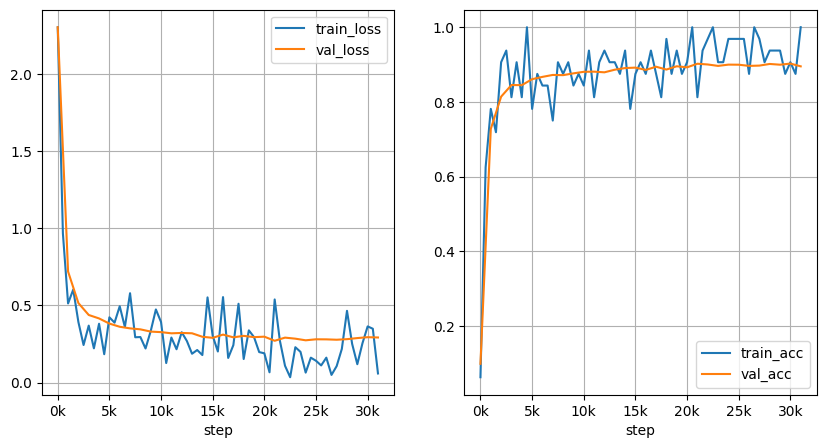

In [20]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        axs[idx].set_xticklabels(map(lambda x: f"{int(x / 1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=500)  #横坐标是 steps

评估

In [21]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/cnn-{activation}/best.ckpt", weights_only=True, map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3191
accuracy: 0.8931


#### selu

In [22]:
epoch = 20

activation = "selu"
model = CNN(activation)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback(f"runs/cnn-{activation}")
tensorboard_callback.draw_model(model, [1, 1, 28, 28])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/cnn-{activation}", save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)

In [23]:
model = model.to(device)
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=1000
)

  0%|          | 0/34380 [00:00<?, ?it/s]

Early stop at epoch 16 / global_step 28000


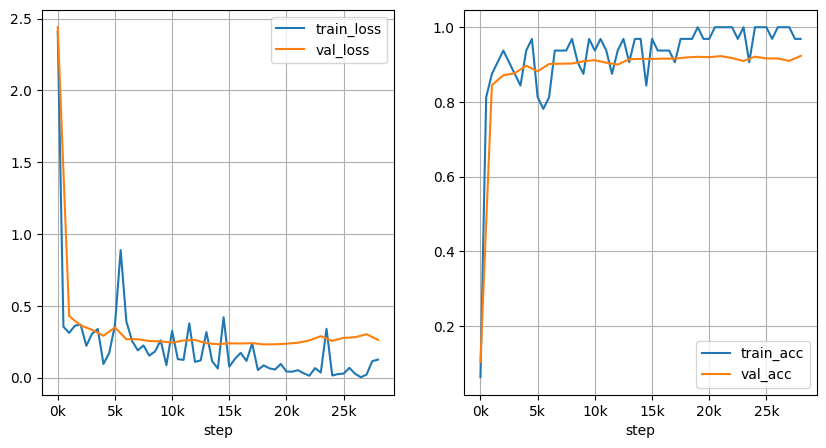

In [24]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        axs[idx].set_xticklabels(map(lambda x: f"{int(x / 1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=500)  #横坐标是 steps

评估

In [25]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/cnn-{activation}/best.ckpt", weights_only=True, map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.2620
accuracy: 0.9184


### homework2：完成深度可分离卷积神经网络对衣服鞋子数据集的分类，对比准确率的差异

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据准备

In [27]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 这里用 random_split 按照 11 : 1 的比例来划分数据集
train_ds, val_ds = random_split(train_ds, [55000, 5000], torch.Generator().manual_seed(seed))

In [28]:
from torchvision.transforms import Normalize


# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


# print(cal_mean_std(train_ds))
# 0.2860， 0.3205
transforms = nn.Sequential(
    Normalize([0.2856], [0.3202])
)

In [29]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32
# 从数据集到dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

定义模型

使用深度可分离的卷积  
pytorch需要自行实现

In [30]:
# 定义深度可分离卷积层
class DepthWiseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        """
        初始化深度可分离卷积层。

        参数:
        - in_channels (int): 输入特征图的通道数。
        - out_channels (int): 输出特征图的通道数。
        - kernel_size (int or tuple): 卷积核的大小。
        - stride (int or tuple, optional): 卷积步幅。默认为1。
        - padding (int or tuple, optional): 输入特征图的填充大小。默认为0。
        - bias (bool, optional): 是否在卷积中使用偏置项。默认为True。
        """
        super(DepthWiseConv2d, self).__init__()  # 调用父类的初始化方法

        # 深度卷积层：每个输入通道使用一个独立的卷积核进行卷积
        # groups=in_channels 表示每个输入通道使用一个独立的卷积核
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels,
                                        bias=False)

        # 逐点卷积层：使用1x1卷积核将深度卷积的输出通道数从in_channels变为out_channels
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=bias)

    def forward(self, x):
        """
        前向传播函数。

        参数:
        - x (torch.Tensor): 输入特征图，形状为 (batch_size, in_channels, height, width)

        返回:
        - torch.Tensor: 输出特征图，形状为 (batch_size, out_channels, height_out, width_out)
        """
        # 首先进行深度卷积
        x = self.depthwise_conv(x)

        # 然后进行逐点卷积
        x = self.pointwise_conv(x)

        return x

In [31]:
class CNN(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        self.activation = F.relu if activation == "relu" else F.selu
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same")
        self.conv2 = DepthWiseConv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = DepthWiseConv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.conv4 = DepthWiseConv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.conv5 = DepthWiseConv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.conv6 = DepthWiseConv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same")
        self.flatten = nn.Flatten()
        # input shape is (28, 28, 1) so the fc1 layer in_features is 128 * 3 * 3
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        act = self.activation
        #x -->(batch_size, 1, 28, 28)
        x = self.pool(act(self.conv2(act(self.conv1(x)))))  # (batch_size, 32, 14, 14)
        x = self.pool(act(self.conv4(act(self.conv3(x)))))  # (batch_size, 64, 7, 7)
        x = self.pool(act(self.conv6(act(self.conv5(x)))))  # (batch_size, 128, 3, 3)
        x = self.flatten(x)  # (batch_size, 128 * 3 * 3)
        x = act(self.fc1(x))  # (batch_size, 128)
        x = self.fc2(x)  # (batch_size, 10)
        return x


for idx, (key, value) in enumerate(CNN().named_parameters()):
    print(f"{key}\tparamerters num: {np.prod(value.shape)}")

conv1.weight	paramerters num: 288
conv1.bias	paramerters num: 32
conv2.depthwise_conv.weight	paramerters num: 288
conv2.pointwise_conv.weight	paramerters num: 1024
conv2.pointwise_conv.bias	paramerters num: 32
conv3.depthwise_conv.weight	paramerters num: 288
conv3.pointwise_conv.weight	paramerters num: 2048
conv3.pointwise_conv.bias	paramerters num: 64
conv4.depthwise_conv.weight	paramerters num: 576
conv4.pointwise_conv.weight	paramerters num: 4096
conv4.pointwise_conv.bias	paramerters num: 64
conv5.depthwise_conv.weight	paramerters num: 576
conv5.pointwise_conv.weight	paramerters num: 8192
conv5.pointwise_conv.bias	paramerters num: 128
conv6.depthwise_conv.weight	paramerters num: 1152
conv6.pointwise_conv.weight	paramerters num: 16384
conv6.pointwise_conv.bias	paramerters num: 128
fc1.weight	paramerters num: 147456
fc1.bias	paramerters num: 128
fc2.weight	paramerters num: 1280
fc2.bias	paramerters num: 10


In [32]:
def count_parameters(model):  #计算模型总参数量
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(CNN())

184234

In [49]:
3 * 3 * 32 * 1 + 32 + 3 * 3 * 32 + 1 * 1 * 32 * 32 + 32 + 3 * 3 * 32 + 1 * 1 * 64 * 32 + 64 + 3 * 3 * 64 + 1 * 1 * 64 * 64 + 64 + 3 * 3 * 64 + 1 * 1 * 128 * 64 + 128 + 3 * 3 * 128 + 1 * 1 * 128 * 128 + 128 + 128 * 3 * 3 * 128 + 128 + 128 * 10 + 10

184234

In [46]:
288 + 288 + 288 + 1024 + 2048 + 576 + 576 + 4096 + 8192 + 1152 + 16384 + 147456 + 1280

183648

In [47]:
32 + 32 + 64 + 64 + 128 + 128 + 128 + 10

586

In [48]:
183648 + 586

184234

训练

In [33]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [34]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [35]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [36]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [37]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [50]:
epoch = 40

activation = "selu"
model = CNN(activation)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback(f"runs/dsc-{activation}")
tensorboard_callback.draw_model(model, [1, 1, 28, 28])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/dsc-{activation}", save_step=len(train_loader),
                                             save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)

In [51]:
model = model.to(device)
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
)

  0%|          | 0/68760 [00:00<?, ?it/s]

Early stop at epoch 32 / global_step 55008


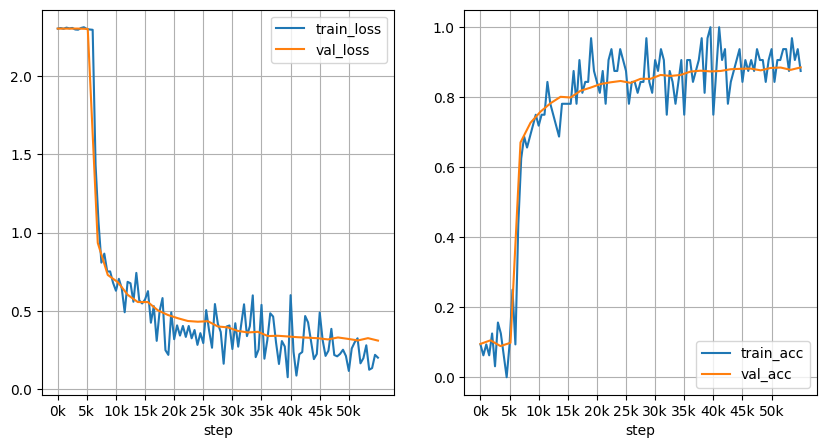

In [52]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        axs[idx].set_xticklabels(map(lambda x: f"{int(x / 1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=500)  #横坐标是 steps

评估

In [53]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/dsc-{activation}/best.ckpt", weights_only=True, map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3127
accuracy: 0.8892


### homework3：使用resnet50实现10-monkeys，和原有经典cnn解决10-monkeys问题进行对比

CNN解决10-monkeys问题

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

数据准备

In [54]:
!tree archive

文件夹 PATH 列表
卷序列号为 000000A3 E62D:21C0
G:\MY_FIRST_GITHUB\HOMEWORK\ARCHIVE
├─training
│  ├─n0
│  ├─n1
│  ├─n2
│  ├─n3
│  ├─n4
│  ├─n5
│  ├─n6
│  ├─n7
│  ├─n8
│  └─n9
└─validation
    ├─n0
    ├─n1
    ├─n2
    ├─n3
    ├─n4
    ├─n5
    ├─n6
    ├─n7
    ├─n8
    └─n9


In [60]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose, ConvertImageDtype, Normalize
from pathlib import Path

# 定义数据集的根目录
DATA_DIR = Path("./archive/")


# 定义一个继承自 `torchvision.datasets.ImageFolder` 的自定义数据集类
class MonkeyDataset(datasets.ImageFolder):
    def __init__(self, mode, transform=None):
        """
        初始化 MonkeyDataset 类。

        参数:
        - mode: 数据集模式，可以是 "train" 或 "val"，分别表示训练集和验证集。
        - transform: 数据预处理操作，如缩放、归一化等。
        """
        # 根据 mode 参数确定数据集的根目录
        if mode == "train":
            root = DATA_DIR / "training"  # 训练集路径
        elif mode == "val":
            root = DATA_DIR / "validation"  # 验证集路径
        else:
            # 如果 mode 不是 "train" 或 "val"，抛出异常
            raise ValueError("mode should be one of the following: train, val, but got {}".format(mode))

        # 调用父类 ImageFolder 的初始化方法，传入根目录和 transform
        super().__init__(root, transform)

        # self.samples 是一个列表，包含图片路径和标签的元组 [(path, label), (path, label),...]
        # 这里将标签提取出来，存储在 self.targets 中
        self.targets = [s[1] for s in self.samples]


# 预先设定的图片尺寸
img_h, img_w = 128, 128

# 定义数据预处理操作
transform = Compose([
    Resize((img_h, img_w)),  # 将图片缩放到指定尺寸 (128x128)
    ToTensor(),  # 将图片转换为 PyTorch 的 Tensor 格式
    # 对图片进行归一化处理，均值和标准差是预先统计的
    Normalize([0.4363, 0.4328, 0.3291], [0.2085, 0.2032, 0.1988]),
    ConvertImageDtype(torch.float),  # 将图片数据类型转换为 float
])

# 创建训练集和验证集实例
train_ds = MonkeyDataset("train", transform=transform)
val_ds = MonkeyDataset("val", transform=transform)

# 打印训练集和验证集的图片数量
print("load {} images from training dataset".format(len(train_ds)))
print("load {} images from validation dataset".format(len(val_ds)))

load 1097 images from training dataset
load 272 images from validation dataset


In [56]:
# 数据类别
train_ds.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [57]:
train_ds.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [82]:
# # 图片路径 及 标签
i = 0
for fpath, label in train_ds.samples:
    print(fpath, label)
    i += 1
    if i == 10:
        break

#这个和之前的dataset完全一致
for img, label in train_ds:
    # c, h, w  label
    print(img.shape, label)
    break

archive\training\n0\n0018.jpg 0
archive\training\n0\n0019.jpg 0
archive\training\n0\n0020.jpg 0
archive\training\n0\n0021.jpg 0
archive\training\n0\n0022.jpg 0
archive\training\n0\n0023.jpg 0
archive\training\n0\n0024.jpg 0
archive\training\n0\n0025.jpg 0
archive\training\n0\n0026.jpg 0
archive\training\n0\n0027.jpg 0
torch.Size([3, 128, 128]) 0


In [61]:
#因为有3通道，所有有3个mean和std
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img[:, :, :].mean(dim=(1, 2))
        std += img[:, :, :].std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
# print(cal_mean_std(train_ds))

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2085, 0.2032, 0.1988]))


In [62]:
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

batch_size = 64
# 从数据集到dataloader，num_workers参数不能加，否则会报错
# https://github.com/pytorch/pytorch/issues/59438
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

定义模型

In [63]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, activation="relu"):
        super().__init__()
        self.activation = F.relu if activation == "relu" else F.selu
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same")
        self.flatten = nn.Flatten()
        # input shape is (3, 128, 128) so the flatten output shape is 128 * 16 * 16
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        act = self.activation
        x = self.pool(act(self.conv2(act(self.conv1(x)))))
        x = self.pool(act(self.conv4(act(self.conv3(x)))))
        x = self.pool(act(self.conv6(act(self.conv5(x)))))
        x = self.flatten(x)
        x = act(self.fc1(x))
        x = self.fc2(x)
        return x


for idx, (key, value) in enumerate(CNN().named_parameters()):
    print(f"{key}\tparamerters num: {np.prod(value.shape)}")

conv1.weight	paramerters num: 864
conv1.bias	paramerters num: 32
conv2.weight	paramerters num: 9216
conv2.bias	paramerters num: 32
conv3.weight	paramerters num: 18432
conv3.bias	paramerters num: 64
conv4.weight	paramerters num: 36864
conv4.bias	paramerters num: 64
conv5.weight	paramerters num: 73728
conv5.bias	paramerters num: 128
conv6.weight	paramerters num: 147456
conv6.bias	paramerters num: 128
fc1.weight	paramerters num: 4194304
fc1.bias	paramerters num: 128
fc2.weight	paramerters num: 1280
fc2.bias	paramerters num: 10


In [64]:
def count_parameters(model):  #计算模型总参数量
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(CNN())

4482730

训练

In [65]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [66]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [67]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [68]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [69]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [70]:
epoch = 20

activation = "relu"
model = CNN(num_classes=10, activation=activation)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback(f"runs/monkeys-cnn-{activation}")
tensorboard_callback.draw_model(model, [1, 3, img_h, img_w])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/monkeys-cnn-{activation}", save_step=len(train_loader),
                                             save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

In [71]:
model = model.to(device)
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
)

  0%|          | 0/360 [00:00<?, ?it/s]

Early stop at epoch 19 / global_step 342


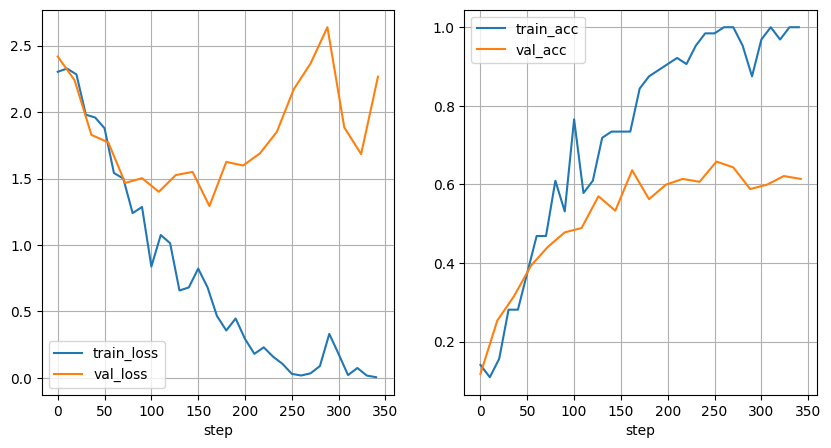

In [77]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10)  #横坐标是 steps

评估

In [80]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(
    torch.load(f"checkpoints/monkeys-cnn-{activation}/best.ckpt", map_location="cpu", weights_only=True))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     2.1709
accuracy: 0.6581


ResNet50解决10-monkeys问题

In [85]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose, ConvertImageDtype, Normalize

from pathlib import Path

DATA_DIR = Path("./archive/")


class MonkeyDataset(datasets.ImageFolder):
    def __init__(self, mode, transform=None):
        if mode == "train":
            root = DATA_DIR / "training"
        elif mode == "val":
            root = DATA_DIR / "validation"
        else:
            raise ValueError("mode should be one of the following: train, val, but got {}".format(mode))
        super().__init__(root, transform)
        self.imgs = self.samples
        self.targets = [s[1] for s in self.samples]


# resnet 要求的，见 https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html
img_h, img_w = 224, 224
transform = Compose([
    Resize((img_h, img_w)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ConvertImageDtype(torch.float),
])

train_ds = MonkeyDataset("train", transform=transform)
val_ds = MonkeyDataset("val", transform=transform)

print("load {} images from training dataset".format(len(train_ds)))
print("load {} images from validation dataset".format(len(val_ds)))

load 1097 images from training dataset
load 272 images from validation dataset


In [86]:
# 数据类别
train_ds.classes,

(['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'],)

In [87]:
train_ds.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [88]:
# 图片路径 及 标签
for fpath, label in train_ds.imgs:
    print(fpath, label)
    break

for img, label in train_ds:
    # c, h, w  label
    print(img.shape, label)
    break

archive\training\n0\n0018.jpg 0
torch.Size([3, 224, 224]) 0


In [84]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
# print(cal_mean_std(train_ds))

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2129, 0.2075, 0.2037]))


In [90]:
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

batch_size = 32
# 从数据集到dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [91]:
for imgs, labels in train_loader:
    print(imgs.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


定义模型

In [92]:
from torchvision.models import resnet50


# 定义一个自定义的ResNet50模型类，继承自nn.Module
class ResNet50(nn.Module):
    def __init__(self, num_classes=10, frozen=True):
        super().__init__()

        # 加载预训练的ResNet50模型，并使用IMAGENET1K_V2的预训练权重
        self.model = resnet50(weights="IMAGENET1K_V2")

        # 如果frozen为True，冻结除指定层外的所有层的权重
        if frozen:
            for param in self.model.parameters():
                param.requires_grad = False  # 冻结所有层的权重

        # 解冻指定层的权重
        for name, param in self.model.named_parameters():
            if name == "layer4.2.conv3.weight":
                param.requires_grad = True  # 解冻layer4中的特定卷积层的权重

        # 打印ResNet50最后一层的输入和输出通道数
        print(self.model.fc.in_features)  # 打印全连接层的输入通道数
        print(self.model.fc.out_features)  # 打印全连接层的输出通道数（默认是1000类）

        # 替换ResNet50的最后一层全连接层，改为自定义的分类层
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # 将输出类别数改为num_classes

    # 定义前向传播函数
    def forward(self, x):
        return self.model(x)


# 遍历模型的每一层，打印每一层的名称和参数数量
for idx, (key, value) in enumerate(ResNet50().named_parameters()):
    print(f"{key:^40} parameters num: {np.prod(value.shape)}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [01:32<00:00, 1.11MB/s]

2048
1000
           model.conv1.weight            parameters num: 9408
            model.bn1.weight             parameters num: 64
             model.bn1.bias              parameters num: 64
      model.layer1.0.conv1.weight        parameters num: 4096
       model.layer1.0.bn1.weight         parameters num: 64
        model.layer1.0.bn1.bias          parameters num: 64
      model.layer1.0.conv2.weight        parameters num: 36864
       model.layer1.0.bn2.weight         parameters num: 64
        model.layer1.0.bn2.bias          parameters num: 64
      model.layer1.0.conv3.weight        parameters num: 16384
       model.layer1.0.bn3.weight         parameters num: 256
        model.layer1.0.bn3.bias          parameters num: 256
   model.layer1.0.downsample.0.weight    parameters num: 16384
   model.layer1.0.downsample.1.weight    parameters num: 256
    model.layer1.0.downsample.1.bias     parameters num: 256
      model.layer1.1.conv1.weight        parameters num: 16384
       mod

In [94]:
# 创建一个ResNet50模型实例，设置输出类别数为10，并冻结除指定层外的所有层
model = ResNet50(num_classes=10, frozen=True)


# 定义一个函数，用于计算模型中可训练参数的总数量
def count_parameters(model):
    """
    计算模型中可训练参数的总数量。

    参数:
    model (nn.Module): PyTorch模型实例。

    返回:
    int: 模型中可训练参数的总数量。
    """
    # 使用生成器表达式遍历模型的所有参数
    # p.numel() 返回参数张量中的元素总数
    # p.requires_grad 为 True 表示该参数是可训练的
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# 调用函数，计算模型中可训练参数的总数量
count_parameters(model)

2048
1000


1069066

In [95]:
model

ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [97]:
# 计算模型中所有参数的总数量（包括可训练和不可训练的）
total_params = sum(p.numel() for p in model.parameters())

# 打印模型中所有参数的总数量
print(f"Total parameters: {total_params}")

Total parameters: 23528522


In [98]:
# 创建一个 AdaptiveAvgPool2d 层，设置输出大小为 (1, 1)
m = nn.AdaptiveAvgPool2d(output_size=(1, 1))

# 创建一个随机输入张量，形状为 (batch_size, channels, height, width)
input = torch.randn(1, 2048, 9, 9)  # batch_size=1, channels=2048, height=9, width=9

# 将输入张量传递给 AdaptiveAvgPool2d 层，得到输出
output = m(input)

# 打印输出的形状
print(output.shape)

torch.Size([1, 2048, 1, 1])


In [99]:
512 * 3 * 3 * 512

2359296

In [100]:
512 * 1 * 1 * 2048

1048576

In [101]:
512 / 16

32.0

训练

In [102]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [103]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [104]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [105]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [106]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [107]:
epoch = 20

model = ResNet50(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 sgd
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
# tensorboard_callback = TensorBoardCallback("runs/monkeys-resnet50")
# tensorboard_callback.draw_model(model, [1, 3, img_h, img_w])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/monkeys-resnet50", save_step=len(train_loader),
                                             save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

2048
1000


In [108]:
model = model.to(device)
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
)

  0%|          | 0/700 [00:00<?, ?it/s]

Early stop at epoch 10 / global_step 350


In [112]:
# 画图

import torch
from torchviz import make_dot

# 假设你的模型已经定义并且命名为 'model'
# 构造一个虚拟输入，形状为 (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 224, 224)  # Replace with your input shape

# 获取模型的设备
device = next(model.parameters()).device

# 将输入数据移动到与模型相同的设备
dummy_input = dummy_input.to(device)

# 执行前向传播
output = model(dummy_input)

# 可视化模型架构
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")  # Save the visualization as an image

'model_architecture.png'

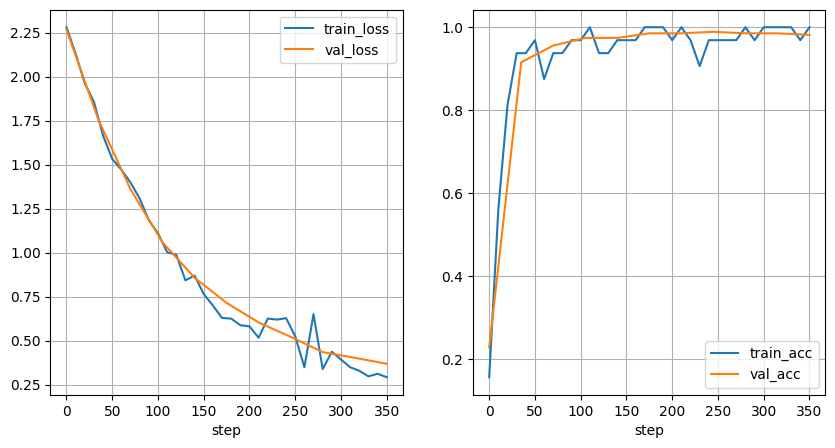

In [110]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10)  #横坐标是 steps

评估

In [111]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/monkeys-resnet50/best.ckpt", map_location="cpu", weights_only=True))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.5212
accuracy: 0.9890


### homework4：完成cifar10的模型搭建

In [170]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据准备

In [171]:
from pathlib import Path

DATA_DIR = Path("G:/my_first_github/data/cifar-10")

train_lables_file = DATA_DIR / "trainLabels.csv"
test_csv_file = DATA_DIR / "sampleSubmission.csv"  #测试集模板csv文件
train_folder = DATA_DIR / "train"
test_folder = DATA_DIR / "test"

#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]


def parse_csv_file(filepath, folder):  #filepath:csv文件路径，folder:图片所在文件夹
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
        #         lines = f.readlines()  为什么加[1:]，可以试这个
        #第一行不需要，因为第一行是标题
        lines = f.readlines()[1:]
    for line in lines:  #依次去取每一行
        image_id, label_str = line.strip('\n').split(',')  #图片id 和标签分离
        image_full_path = folder / f"{image_id}.png"
        results.append((image_full_path, label_str))  #得到对应图片的路径和分类
    return results


#解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint

pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[(WindowsPath('G:/my_first_github/data/cifar-10/train/1.png'), 'frog'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/2.png'), 'truck'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/3.png'), 'truck'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/4.png'), 'deer'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/5.png'), 'automobile')]
[(WindowsPath('G:/my_first_github/data/cifar-10/test/1.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/2.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/3.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/4.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/5.png'), 'cat')]
50000 300000


In [172]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])  # 取前45000张图片作为训练集
valid_df = pd.DataFrame(train_labels_info[45000:])  # 取后5000张图片作为验证集
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                                       filepath       class
0  G:\my_first_github\data\cifar-10\train\1.png        frog
1  G:\my_first_github\data\cifar-10\train\2.png       truck
2  G:\my_first_github\data\cifar-10\train\3.png       truck
3  G:\my_first_github\data\cifar-10\train\4.png        deer
4  G:\my_first_github\data\cifar-10\train\5.png  automobile
                                           filepath       class
0  G:\my_first_github\data\cifar-10\train\45001.png       horse
1  G:\my_first_github\data\cifar-10\train\45002.png  automobile
2  G:\my_first_github\data\cifar-10\train\45003.png        deer
3  G:\my_first_github\data\cifar-10\train\45004.png  automobile
4  G:\my_first_github\data\cifar-10\train\45005.png    airplane
                                      filepath class
0  G:\my_first_github\data\cifar-10\test\1.png   cat
1  G:\my_first_github\data\cifar-10\test\2.png   cat
2  G:\my_first_github\data\cifar-10\test\3.png   cat
3  G:\my_first_github\data\cifar-10\test\4.p

In [173]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Cifar10Dataset(Dataset):
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }
    label_to_idx = {label: idx for idx, label in enumerate(class_names)}  # 类别映射为idx
    idx_to_label = {idx: label for idx, label in enumerate(class_names)}  # idx映射为类别,为了test测试集使用

    def __init__(self, mode, transform=None):
        self.df = self.df_map.get(mode, None)  # 获取对应模式的df，不同字符串对应不同模式
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))
        # assert self.df, "df is None"
        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.df.iloc[index]  # 获取图片路径和标签
        img = Image.open(img_path).convert('RGB')
        # # img 转换为 channel first
        # img = img.transpose((2, 0, 1))
        # transform
        img = self.transform(img)  # 数据增强
        # label 转换为 idx
        label = self.label_to_idx[label]
        return img, label

    def __len__(self):
        return self.df.shape[0]  # 返回df的行数,样本数


IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transforms_train = transforms.Compose([
    # resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  #缩放
    # random rotation 40
    transforms.RandomRotation(40),  #随机旋转
    # horizaontal flip
    transforms.RandomHorizontalFlip(),  #随机水平翻转
    transforms.ToTensor(),  #转换为tensor
    transforms.Normalize(mean, std) #标准化
])  #数据增强

transforms_eval = transforms.Compose([
    # resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
# ToTensor还将图像的维度从[height, width, channels]转换为[channels, height, width]。
train_ds = Cifar10Dataset("train", transforms_train)
eval_ds = Cifar10Dataset("eval", transforms_eval)

In [174]:
train_ds[0][0].shape  # 图片的shape,输入

torch.Size([3, 32, 32])

In [175]:
print(train_ds.idx_to_label)  # 类别映射为idx
train_ds.label_to_idx  # idx映射为类别

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [176]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False)

In [177]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


# 经过 normalize 后 均值为0，方差为1
print(cal_mean_std(train_ds))

(tensor([-0.2207, -0.2281, -0.1986]), tensor([0.9977, 0.9955, 0.9043]))


定义模型

In [178]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),  # 批标准化，在通道数做的归一化
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),  #输出尺寸（128，32，32）
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),  #输出尺寸（128，16，16）
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"),  #输出尺寸（256，16，16）
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),  #输出尺寸（256，8，8）
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),  #输出尺寸（512，8，8）
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2),  #输出尺寸（512，4，4）
            nn.Flatten(),  #展平
            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )  #Sequential自动连接各层，把各层的输出作为下一层的输入

    def forward(self, x):
        return self.model(x)


for key, value in CNN(len(class_names)).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

             model.0.weight             paramerters num: 3456
              model.0.bias              paramerters num: 128
             model.2.weight             paramerters num: 128
              model.2.bias              paramerters num: 128
             model.3.weight             paramerters num: 147456
              model.3.bias              paramerters num: 128
             model.5.weight             paramerters num: 128
              model.5.bias              paramerters num: 128
             model.7.weight             paramerters num: 294912
              model.7.bias              paramerters num: 256
             model.9.weight             paramerters num: 256
              model.9.bias              paramerters num: 256
            model.10.weight             paramerters num: 589824
             model.10.bias              paramerters num: 256
            model.12.weight             paramerters num: 256
             model.12.bias              paramerters num: 256
            mo

In [179]:
total_params = sum(p.numel() for p in CNN(len(class_names)).parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 8779914


In [180]:
512 * 4 * 4

8192

In [181]:
input_4d = torch.randn(32, 3, 64, 64)  # 32 个样本，3 个通道，图像大小为 64x64
bn2d = nn.BatchNorm2d(3)  # 对 3 个通道进行归一化
output_4d = bn2d(input_4d)
output_4d.shape

torch.Size([32, 3, 64, 64])

In [182]:
output_4d

tensor([[[[-9.2388e-01, -3.5268e-01,  3.8138e-01,  ...,  1.1995e+00,
           -1.8043e+00, -2.5214e+00],
          [ 8.5671e-01,  1.3547e+00,  1.0829e+00,  ..., -8.9794e-01,
           -6.4836e-02, -5.6386e-01],
          [ 1.2787e+00, -6.0884e-02, -6.4668e-01,  ...,  1.9123e-01,
            6.6458e-01, -1.1659e+00],
          ...,
          [-9.0075e-01,  2.4802e+00, -7.8640e-01,  ...,  1.8228e+00,
            4.5067e-01,  1.2095e+00],
          [-1.3548e+00, -1.0631e+00, -8.9090e-02,  ..., -7.5243e-01,
           -5.5007e-02, -8.7224e-01],
          [ 5.3793e-01,  6.6744e-01, -1.5315e-01,  ..., -1.7710e+00,
            5.1205e-01,  8.1495e-01]],

         [[-9.3322e-01, -1.0056e+00,  8.6877e-01,  ..., -4.1407e-01,
            2.3559e-01, -8.0006e-01],
          [-4.4108e-01,  8.1135e-01, -3.8448e-01,  ..., -6.7019e-01,
            1.5367e+00,  8.4198e-01],
          [ 2.1421e+00, -6.2017e-01, -8.9885e-01,  ..., -2.6025e-01,
            2.1859e-01,  5.9292e-03],
          ...,
     

In [183]:
bn2d = nn.BatchNorm2d(1)  # 对 3 个通道进行归一化
output_4d1 = bn2d(input_4d[:, 0:1, :, :])
output_4d1

tensor([[[[-0.9239, -0.3527,  0.3814,  ...,  1.1995, -1.8043, -2.5214],
          [ 0.8567,  1.3547,  1.0829,  ..., -0.8979, -0.0648, -0.5639],
          [ 1.2787, -0.0609, -0.6467,  ...,  0.1912,  0.6646, -1.1659],
          ...,
          [-0.9008,  2.4802, -0.7864,  ...,  1.8228,  0.4507,  1.2095],
          [-1.3548, -1.0631, -0.0891,  ..., -0.7524, -0.0550, -0.8722],
          [ 0.5379,  0.6674, -0.1531,  ..., -1.7710,  0.5120,  0.8150]]],


        [[[-0.0553, -0.1238, -0.4338,  ...,  0.5346, -0.1533,  0.3308],
          [-0.4185,  0.7688,  1.6704,  ...,  0.9422,  0.3839, -0.6612],
          [-0.8147, -2.3391, -0.1799,  ...,  1.4345, -1.0866,  0.8407],
          ...,
          [-1.9018, -0.1589,  0.3014,  ..., -1.0515,  0.2455, -0.8174],
          [ 0.3510, -0.9806, -0.6268,  ...,  0.0923,  0.1754,  1.0853],
          [ 1.0163, -1.8100,  0.5627,  ..., -0.8237,  1.4667, -1.0783]]],


        [[[ 0.0213, -0.6613, -0.2256,  ..., -0.1213, -0.5837,  0.6400],
          [ 0.1750, -0.502

训练

In [184]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [185]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [186]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [187]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [188]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)  #最大值的索引

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())  # 计算准确率
                loss = loss.cpu().item()  # 计算损失
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step  # 记录每一步的损失和准确率
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [189]:
epoch = 20

model = CNN(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/cifar-10")
tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/cifar-10", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

In [190]:
model = model.to(device)
record = training(
    model,
    train_dl,
    eval_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
)

  0%|          | 0/14080 [00:00<?, ?it/s]

Early stop at epoch 16 / global_step 11264


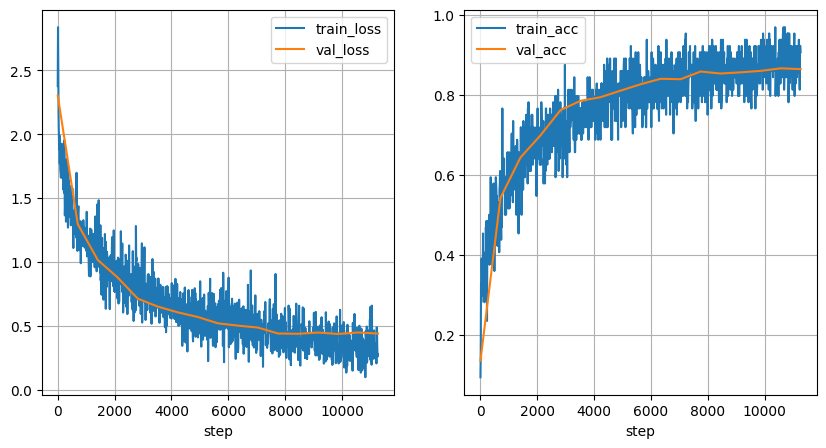

In [191]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10)  #横坐标是 steps

评估

In [192]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/cifar-10/best.ckpt", map_location="cpu", weights_only=True))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.4502
accuracy: 0.8660


推理

In [193]:
# test_df
test_ds = Cifar10Dataset("test", transform=transforms_eval)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

preds_collect = []  # 预测结果收集器
model.eval()
for data, fake_label in tqdm(test_dl):
    data = data.to(device=device)
    logits = model(data)  #得到预测结果
    preds = [test_ds.idx_to_label[idx] for idx in
             logits.argmax(axis=-1).cpu().tolist()]  # 得到预测类别，idx_to_label是id到字符串类别的映射
    preds_collect.extend(preds)

test_df["label"] = preds_collect  # 增加预测类别列,比赛要求这一列是label
test_df.head()

  0%|          | 0/4688 [00:00<?, ?it/s]

,filepath,class,label
0,G:\my_first_github\data\cifar-10\test\1.png,cat,truck
1,G:\my_first_github\data\cifar-10\test\2.png,cat,airplane
2,G:\my_first_github\data\cifar-10\test\3.png,cat,automobile
3,G:\my_first_github\data\cifar-10\test\4.png,cat,ship
4,G:\my_first_github\data\cifar-10\test\5.png,cat,airplane


In [194]:
64 * 4688

300032

In [195]:
# 导出 submission.csv
test_df.to_csv("submission.csv", index=False)